# RQ1 How long it took developers to adopt safetensors after its first release?

Goal is to check when safetensors was first used in each studied repository.    

## Select group first

In [74]:
group_under_analysis = 'both'  # change this to 'legacy' or 'recent' to analyze the corresponding dataset

## Read the data

In [75]:
from nb_utils import read_repositories_evolution

# model files per repository and the elapsed days between the commit and safetensors' release date
df = read_repositories_evolution(group_under_analysis)

# Filter out rows with 'safetensors' serialization format and that added  safetensors files
df_safetensors = df[(df[ 'serialization_format'] == 'safetensors') & (df['change_status'] == '+')]

(df_safetensors['date'].min(),
 df_safetensors['date'].max(),
 df_safetensors['elapsed_days'].min(),
 df_safetensors['elapsed_days'].max())

100%|██████████| 51900/51900 [00:00<00:00, 70475.71commit/s]


(Timestamp('2022-09-29 11:21:48'), Timestamp('2024-12-31 09:57:22'), 7, 831)

## Analysis 1: How many commits containing safetensors files were made by HF's conversion tool?

HuggingFace has a [tool](https://huggingface.co/spaces/safetensors/convert) that converts models to safetensors. Thus, we want to study:
    - how many commits adding safetensors files were made by the tool?
    - how many commits adding safetensors files were made by developers themselves?
Hugging Face bot's source code: https://github.com/huggingface/safetensors/commits/main/bindings/python/convert.py

In [76]:
from nb_utils import RESULTS_DIR
from nb_utils import get_commit_log_stats

stats, total_touching_model_files, total_adding_model_files = get_commit_log_stats(df, group_under_analysis)

# check if the message contains the auto-converter message
bot_message = "Adding `safetensors` variant of this model"
df_safetensors_not_by_tool = df_safetensors[~df_safetensors['message'].str.contains(bot_message)]
df_safetensors_by_tool = df_safetensors[df_safetensors['message'].str.contains(bot_message)]

# compute number of unique repo_url and commit_hash combination in df
num_safetensors_commits = len(df_safetensors[['repo_url', 'commit_hash']].drop_duplicates())
num_repos_with_safetensors_commits = df_safetensors['repo_url'].nunique()
num_safetensors_commits_by_bot = len(df_safetensors_by_tool[['repo_url', 'commit_hash']].drop_duplicates())
num_repos_with_safetensors_commits_by_bot = len(df_safetensors_by_tool['repo_url'].unique())
num_safetensors_commits_not_by_bot = len(df_safetensors_not_by_tool[['repo_url', 'commit_hash']].drop_duplicates())
num_repos_with_safetensors_commits_not_by_bot = len(df_safetensors_not_by_tool['repo_url'].unique())
date_with_max_adoptions = df_safetensors[df_safetensors['elapsed_days'] == df_safetensors['elapsed_days'].mode().values[0]].iloc[0]['date']
# Compute some more statistics to be saved
stats.loc['# commits adding safetensor files'] = num_safetensors_commits
stats.loc['# repos with commits adding safetensor files'] = num_repos_with_safetensors_commits
stats.loc['# commits adding safetensor files made by the converter'] = num_safetensors_commits_by_bot
stats.loc['# repos with commits adding safetensor files made by the converter'] = num_repos_with_safetensors_commits_by_bot
stats.loc['# commits adding safetensor files made by developers'] = num_safetensors_commits_not_by_bot
stats.loc['# repos with commits adding safetensor files made by developers'] = num_repos_with_safetensors_commits_not_by_bot
stats.loc['how many days until safetensors is first added'] = df_safetensors['elapsed_days'].min()
stats.loc['date with max number of adoptions'] = str(date_with_max_adoptions).split(" ")[0]
stats.to_csv(RESULTS_DIR / f'rq1_dataset_stats_{group_under_analysis}.csv', header=False)

# save the dataframes
df_safetensors_not_by_tool.to_csv(RESULTS_DIR / f'safetensors_commits_not_by_tool_{group_under_analysis}.csv', index=False)
df_safetensors_by_tool.to_csv(RESULTS_DIR / f'safetensors_commits_by_tool_{group_under_analysis}.csv', index=False)
stats

# commits modifying/adding/deleting at least one serialized model                                                           22305
# commits adding at least one serialized model                                                                              19200
# commits in all logs (total)                                                                                               57149
# commits containing at least one model file in its tree                                                                    22219
# repos associated with commits modifying/adding/deleting at least one serialized model                                      3406
# repos                                                                                                                      3406
last commit date                                                                           2024-12-31 12:30:542024-12-30 11:22:26
# repos associated with commits adding at least one serialized model                      

## Analysis 2: Number of elapsed days since the release of safetensors

This script checks how long it took safetensors to first appear in each analyzed repository.

### What repos were the fastest to adopt safetensors after its release?

In [77]:

import pandas as pd
from nb_utils import SAFETENSORS_RELEASE_DATE, RESULTS_DIR
safetensors_first_appearance = df_safetensors.groupby('repo_url')['elapsed_days'].min().sort_values()
safetensors_first_appearance = safetensors_first_appearance.reset_index()
safetensors_first_appearance['date'] = safetensors_first_appearance['elapsed_days'].apply(lambda x: SAFETENSORS_RELEASE_DATE + pd.Timedelta(days=x))

safetensors_first_appearance.head(10)




,repo_url,elapsed_days,date
0,FacebookAI/roberta-large,7,2022-09-29
1,FacebookAI/roberta-base,7,2022-09-29
2,openai-community/gpt2,7,2022-09-29
3,bigscience/bloomz,42,2022-11-03
4,google-bert/bert-large-uncased,53,2022-11-14
5,distilbert/distilgpt2,53,2022-11-14
6,distilbert/distilroberta-base,55,2022-11-16
7,google-bert/bert-base-uncased,55,2022-11-16
8,distilbert/distilbert-base-uncased,55,2022-11-16
9,google-bert/bert-base-multilingual-cased,55,2022-11-16


### Who made the first adoption of safetensors?

In [ ]:
first_adoption_commits = df_safetensors[df_safetensors['elapsed_days'] == df_safetensors['elapsed_days'].min()]
for index, row in first_adoption_commits.iterrows():
    print(f"Repository: {row['repo_url']}")
    print(f"\tCommit: {row['commit_hash']}, Date: {row['date'].strftime('%Y-%m-%d')}, Author: {row['author']}")


### After which date was most (80%) of the adoptions?

In [70]:
from nb_utils import SAFETENSORS_RELEASE_DATE

# Calculate the 80% threshold
threshold = 0.80 * len(df_safetensors)
# Sort the DataFrame by elapsed_days
safetensors_first_appearance_sorted = safetensors_first_appearance.sort_values(by='elapsed_days')
# Find the index where the cumulative count reaches or exceeds the threshold
cumulative_counts = safetensors_first_appearance_sorted['elapsed_days'].cumsum()
index_80_percent = cumulative_counts[cumulative_counts >= threshold].index[0]
# Get the date corresponding to that index
date_80_percent = safetensors_first_appearance_sorted.iloc[index_80_percent]['date']
# Print the date
print(
    f"80% of the adoptions happened after {date_80_percent.strftime('%Y-%m-%d')}, which is {date_80_percent - SAFETENSORS_RELEASE_DATE} days after the first safetensors release.")

80% of the adoptions happened after 2023-02-07, which is 138 days 00:00:00 days after the first safetensors release.


## Analysis 3: Plot the number of adoptions per elapsed days

Since the first safetensors release, shows the number of model files using safetensors per elapsed days.

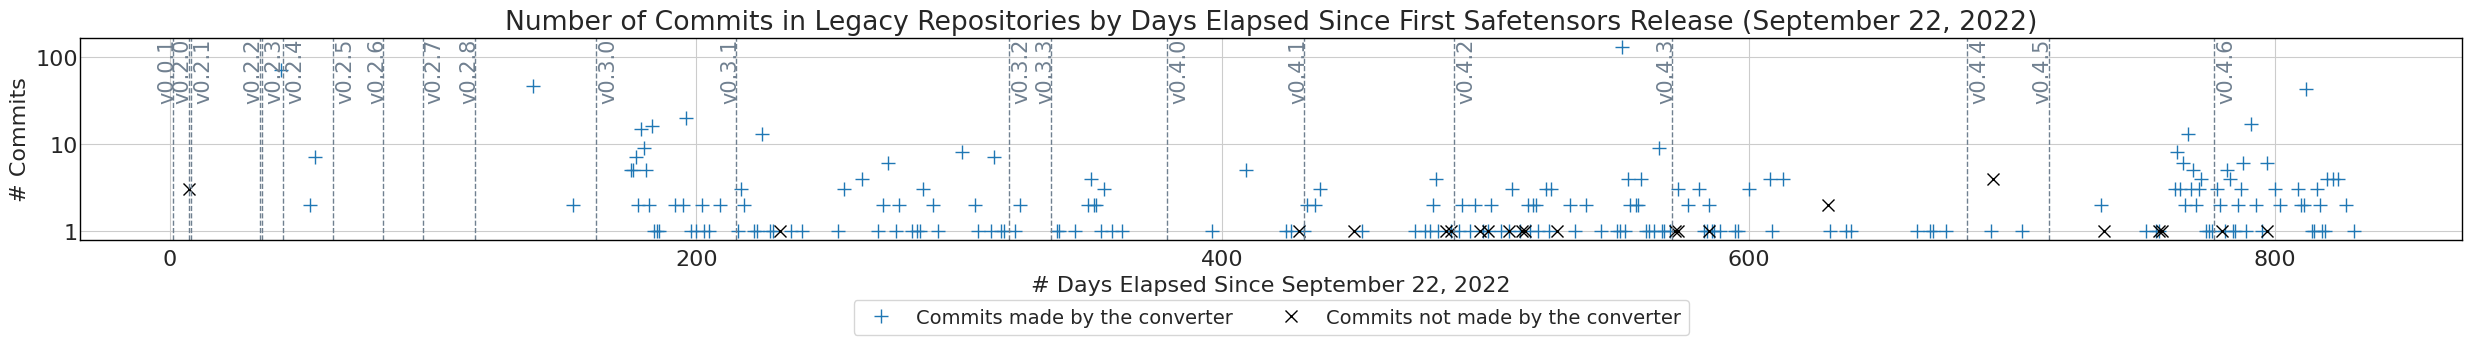

In [71]:
import matplotlib.pyplot as plt
from nb_utils import get_safetensors_releases, SAFETENSORS_RELEASE_DATE

# Group by elapsed days to count files modified on each date
all_commits = df_safetensors['elapsed_days'].value_counts().sort_index()
commits_not_by_bot = df_safetensors_not_by_tool['elapsed_days'].value_counts().sort_index()
commits_by_bot = df_safetensors_by_tool['elapsed_days'].value_counts().sort_index()

# Set a different font with broad Unicode support
plt.rcParams['font.family'] = 'DejaVu Sans'
# Decrease padding for y-axis tick labels
plt.rcParams['ytick.major.pad'] = -2  # Decrease this value as needed
# specify default font size
plt.rcParams.update({'font.size': 16})

# Plotting
plt.figure(figsize=(25, 4), facecolor="white")  # Set figure background to white
ax = plt.gca()  # Get the current axis
ax.set_facecolor("white")  # Set axis background to white

# Ensure the visibility of x-axis and y-axis lines (spines)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.0)

plt.plot(commits_by_bot.index, commits_by_bot.values,
         marker='+', linestyle='None', markersize=10)
plt.plot(commits_not_by_bot.index, commits_not_by_bot.values,
         marker='x', linestyle='None', color='black', markersize=9)

plt.xlabel("# Days Elapsed Since September 22, 2022")
plt.ylabel("# Commits")
plt.title(
    f"Number of Commits in {group_under_analysis.capitalize()} Repositories by Days Elapsed Since First Safetensors Release (September 22, 2022)")
plt.yscale('log')
plt.yticks([1, 10, 100], ['1', '10', '100'])
# plt.xticks(fontsize=14)
plt.grid(True)
plt.legend(
    ('Commits made by the converter', 'Commits not made by the converter'),
    loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=14)
plt.tight_layout()

df_releases = get_safetensors_releases()

#  add vertical lines for each release date with labels
color, i, x_coordinates = 'slategray', 0, [0.75, -6]

for day, label in df_releases[['date', 'tag']].values:
    i = (i + 1) % 2
    diff = (day - SAFETENSORS_RELEASE_DATE).days
    plt.axvline(x=diff, color=color, linestyle='--', linewidth=1)
    x_offset = x_coordinates[0] if label == 'v0.2.4' else x_coordinates[i]
    plt.text(diff + x_offset, plt.ylim()[1] * 0.99, label, color=color, rotation=90, verticalalignment='top',
             fontdict={'size': 15})
    if label == 'v0.0.1': i = 2

# Save the plot as a PDF file
plt.savefig(RESULTS_DIR / f'RQ1CommitsDistribution_{group_under_analysis}.pdf', format="pdf", bbox_inches="tight")

plt.show()

## Analysis 4: Number of adoptions as heatmap

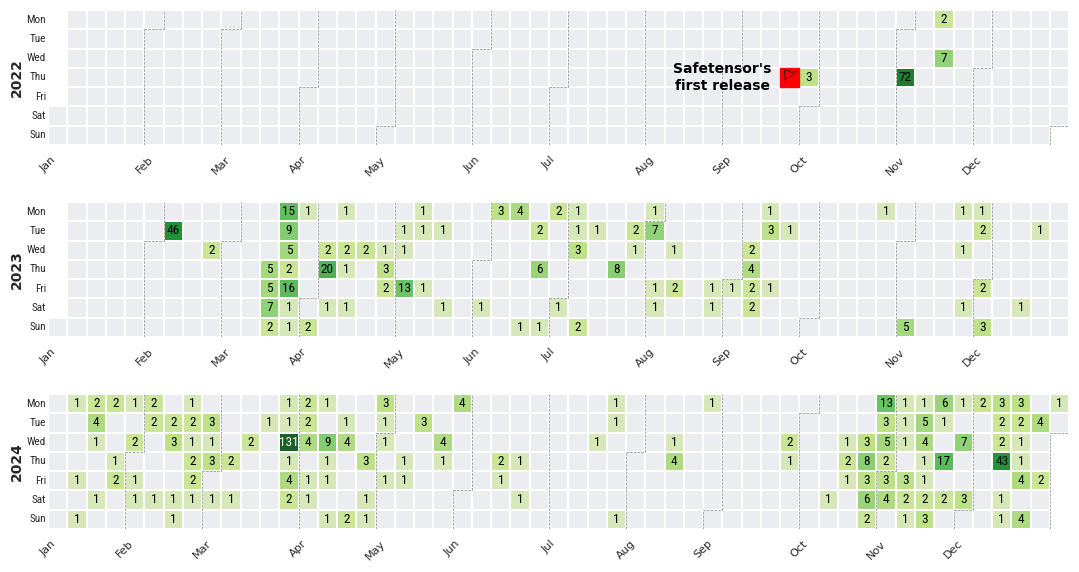

In [72]:
import datetime
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import calendar
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from nb_utils import RESULTS_DIR, ROBOTO_CONDENSED_FONT, EMOJI_FONT
from nb_utils import get_commit_counts_by_date
from nb_utils import compute_calendar_mask
from nb_utils import compute_calendar_week
from nb_utils import compute_year_range
from matplotlib.axes import Axes
# Warnings are very unnecessary. They can only do harm  🎶
# Enjoy the silence :)
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


def overlay_white_boxes(ax: Axes, mask):
    """Draw white boxes over masked (invalid) cells."""
    n_rows, n_cols = mask.shape
    for row in range(n_rows):
        for col in range(n_cols):
            if mask[row, col]:
                # Draw a white square at (col, row)
                rect = Rectangle((col, row), 1, 1, linewidth=0, edgecolor='none', facecolor='white')
                ax.add_patch(rect)


def plot_end_of_month_lines(ax: Axes, row: int, col: int) -> None:
    """
    Plot vertical and horizontal lines to indicate the end of the month in the heatmap.
    :param ax: Axes object to plot on. 
    :param row: The day of the week (0=Monday, 6=Sunday)
    :param col: The week number (0-52)
    """
    y_boundary = (6 - row) * (1 / 7)
    ax.axvline(x=col + 1, ymin=y_boundary, ymax=1, color='gray', linestyle='--', linewidth=0.5)
    if row != 6:
        ax.hlines(row + 1, col, col + 1, color='gray', linestyle='--', linewidth=0.5)
        ax.axvline(x=col, ymin=0, ymax=y_boundary, color='gray', linestyle='--', linewidth=0.5)


def plot_safetensors_marker(ax: Axes) -> None:
    """
    Plot a marker on the heatmap to indicate the first release of safetensors.
    :param ax: axes object to plot on.
    """
    # Define the day (Thursday) and week position to highlight
    highlight_day, highlight_week = 3, 38
    # Add a red patch to highlight the selected square
    ax.add_patch(Rectangle((highlight_week, highlight_day), 1, 1, fill=True, color="red"))
    # Add a text annotation to highlight the selected square
    ax.text(highlight_week - 3, highlight_day+0.5, "Safetensor's\nfirst release",
            ha='center', va='center', color="black", fontsize=10, weight='bold')
    # Add a vertical line to highlight the selected week
    ax.text(highlight_week + 0.5, highlight_day + 0.5, "🚩",
            fontproperties=EMOJI_FONT, ha='center', va='center', fontsize=10, color='black')


def plot_year_heatmap(year: int, ax: Axes, include_dates: bool = False, include_month_markers: bool = False) -> None:
    # Create a DataFrame with dates for the specified year and apply log-transformed data
    year_data = log_commits_by_date[log_commits_by_date.index.year == year]  # log-based counts
    year_data_original = commits_by_date[commits_by_date.index.year == year]  # Original counts 

    # reindex the data to ensure all days of the year are present (filling missing days with 0)
    year_data = year_data.reindex(compute_year_range(year), fill_value=0)
    year_data_original = year_data_original.reindex(compute_year_range(year), fill_value=0)

    # Create a matrix for days (rows) and weeks (columns) for a horizontal layout
    year_matrix, year_matrix_original = np.zeros((7, 53)), np.zeros((7, 53))
    for i, (date, value) in enumerate(year_data.items()):
        if date.year == year:  # skip dates from other years           
            week = compute_calendar_week(date)
            day = date.weekday()
            year_matrix[day, week] = value
            year_matrix_original[day, week] = year_data_original[date]  # Original count for annotation
            # if it is the last day of the month, then add a dashed line around it to mark  end of the month
            if date.month != (date + datetime.timedelta(days=1)).month and include_month_markers:
                plot_end_of_month_lines(ax, day, week)

    # Plot the heatmap with log-transformed data
    mask = compute_calendar_mask(year_matrix, year)
    year_matrix_masked = year_matrix.copy()
    year_matrix_masked[mask] = np.nan
    overlay_white_boxes(ax, mask)
    sns.heatmap(year_matrix, ax=ax, cmap=cmap, cbar=False, vmin=0, vmax=vmax_log, linewidths=0.01, linecolor='white',
                square=True, yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                mask=mask)

    # offset based on what weekday the year starts
    offset = datetime.date(year, 1, 1).weekday()
    # Add annotations for non-zero values
    for row in range(7):
        for col in range(53):
            if year_matrix_original[row, col] > 0:
                ax.text(col + 0.5, row + 0.5, f"{int(year_matrix_original[row, col])}",
                        ha='center', va='center', fontsize=9.5, fontproperties=ROBOTO_CONDENSED_FONT,
                        color='black' if year_matrix_original[row, col] < 0.8 * vmax else 'white')
            elif include_dates:  # add the month day 
                curr_date = datetime.date(year, 1, 1) + datetime.timedelta(days=(col * 7 + row - offset))
                ax.text(col + 0.5, row + 0.5, f"{curr_date.day}", ha='center', va='bottom',
                        fontsize=6, color='black', fontproperties=ROBOTO_CONDENSED_FONT)

    # Set title and adjust labels for horizontal orientation
    # ax.set_title(f"{year}")
    # Add a custom title to the left of the y-axis
    ax.text(-1.25, 3.5, f"{year}", fontsize=10, rotation=90, va='center', ha='right', fontweight='bold',
            transform=ax.transData)

    ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    # Set font family for the labels
    for label in ax.get_yticklabels():
        label.set_fontproperties(ROBOTO_CONDENSED_FONT)
        label.set_fontsize(8)
        label.set_verticalalignment('center')  # make label as close as possible to chart

    # Adjust the month labels along the x-axis
    month_ticks = []
    for month in range(1, 13):
        first_day = datetime.date(year, month, 1)
        week = compute_calendar_week(first_day)
        month_ticks.append(week)
    ax.set_xticks(month_ticks)
    ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=45, fontsize=8)

    # Add safetensors marker on Sep 22, 2022
    if year == 2022: plot_safetensors_marker(ax)


# Define a color map similar to GitHub's green color scheme
colors = ["#ebedf0", "#c6e48b", "#7bc96f", "#239a3b", "#196127"]
cmap = LinearSegmentedColormap.from_list("github_green", colors)

# Set a different font with broad Unicode support
plt.rcParams['font.family'] = 'DejaVu Sans'

# Decrease padding for y-axis tick labels
plt.rcParams['ytick.major.pad'] = -2  # Decrease this value as needed

# Get commit counts by date
commits_by_date, log_commits_by_date, vmax, vmax_log = get_commit_counts_by_date(df_safetensors)
# Define the years for which we want to create heatmaps
years = [2022, 2023, 2024]

# Plot horizontal heatmaps with annotations for non-zero values
fig, axes = plt.subplots(len(years), 1, figsize=(30, 6))
for i, year in enumerate(years):
    plot_year_heatmap(year, axes[i], include_month_markers=True, include_dates=False)

# Save the figure
plt.tight_layout()
plt.savefig(RESULTS_DIR / f'RQ1Heatmap_{group_under_analysis}.pdf', bbox_inches='tight', format='pdf')
plt.show()

## Analysis 5: After using safetensors are developers deleting the old model files?



In [73]:
import pandas as pd
from pathlib import Path
if group_under_analysis != 'both':
    df_commits = pd.read_csv(Path(f'../../data/selected_{group_under_analysis}_commits.csv'))
    # sort frame by repo and date
    df_commits['date'] = pd.to_datetime(df_commits['date'])
    df_commits = df_commits.sort_values(by=['repo_url', 'date'], ascending=[True, False])
    # get the last commit for each repo
    df_latest_commits = df_commits.groupby('repo_url').first()
    df_latest_commits.reset_index(inplace=True)
    
    # only keep in df_latest_commits those whose repo_url are in df_safetensors_by_tool
    df_latest_commits = df_latest_commits[df_latest_commits['repo_url'].isin(df_safetensors_by_tool['repo_url'])]
    
    df_repos_with_old_files = pd.DataFrame(columns=df_latest_commits.columns)
    # find the files in the last commit and whether they still contain the old model files
    for index, row in df_latest_commits.iterrows():
        files = row['all_files_in_tree'].split(";")
        if 'pytorch_model.bin' in files:
            # add to df_repos_with_old_files
            df_repos_with_old_files = pd.concat([df_repos_with_old_files, row.to_frame().T])
    
    print(f"Group: {group_under_analysis}")
    print(f"\t# repos that used the conversion tool: {len(df_safetensors_by_tool['repo_url'].unique())}")
    print(f"\t# repos with old `pytorch_model.bin` file after conversion: {len(df_repos_with_old_files)}")
    print(f"\t% repos with old files: {len(df_repos_with_old_files) / len(df_safetensors_by_tool['repo_url'].unique()) * 100:.2f}%")
    
    stats.loc['# repos that used the conversion tool'] = len(df_safetensors_by_tool['repo_url'].unique())
    stats.loc['# repos with old pytorch_model.bin files after conversion'] = len(df_repos_with_old_files)
    stats.loc['% repos with old pytorch_model.bin files after conversion'] = len(df_repos_with_old_files) / len(df_safetensors_by_tool['repo_url'].unique()) * 100
    stats.to_csv(RESULTS_DIR / f'rq1_dataset_stats_{group_under_analysis}.csv', header=False)
    

Group: legacy
	# repos that used the conversion tool: 628
	# repos with old `pytorch_model.bin` file after conversion: 620
	% repos with old files: 98.73%
